In [1]:
# Import Libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn

In [2]:
#Datasets Used
datasetNames = ["CIFAR10", "MNIST", "FashionMNIST","Moon_Craters"] 

In [3]:
code = 4
# Define a batch size for data processing with a value of 124
BATCH_SIZE=124
# Define a batch size for data processing with a value of 4
BATCH_SIZE2= 4

In [6]:

if code ==1:
# For CIFAR-10 dataset
    NUM_CHANNELS = 3
    # Data transformations for CIFAR-10 dataset
    transform = transforms.Compose(
    
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])
    

    # Training and test data loaders for MNIST dataset
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=2)



if code ==2:
    # For MNIST dataset
    NUM_CHANNELS = 1

    # Data transformations for MNIST dataset
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32)),
        ])

    trainset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)


    testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

if code ==3:
    # For Fashion MNIST dataset
    NUM_CHANNELS = 1

    # Data transformations for Fashion MNIST dataset
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32)),
        ])
    # Training and test data loaders for Fashion MNIST dataset
    trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
    trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)


    testset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

if code==4:
    # For dataset moon craters
    NUM_CHANNELS=1
    # Data transformations for custom dataset
    transform = transforms.Compose([
        # transforms.RandomRotation(degrees=30),
        transforms.Resize((128, 128)),  # Resize images to 224x224
        transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
        transforms.ToTensor(),           # Convert images to PyTorch tensors
        transforms.Normalize(mean=[0], std=[1]) 
    ])


    transform2 = transforms.Compose([
        # transforms.RandomRotation(degrees=30),
        transforms.Resize((128, 128)),  # Resize images to 224x224
        transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
        transforms.ToTensor(),           # Convert images to PyTorch tensors
        transforms.Normalize(mean=[0], std=[1]) 
    ])

    # Directories for train and test sets
    train_dir = "Datasets/craters/train/"
    test_dir = "Datasets/craters/test/"
    # Training set and test set loaders for custom dataset

    trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)


    trainset2 = torchvision.datasets.ImageFolder(root=train_dir, transform=transform2)
    trainloader2 = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)


    testset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE2, shuffle=True)


    for batch_idx, (images, labels) in enumerate(trainloader):
        # Process the batch as needed
        print(f"Batch {batch_idx}: Images shape: {images.shape}, Labels shape: {labels.shape}")



Batch 0: Images shape: torch.Size([124, 1, 128, 128]), Labels shape: torch.Size([124])


(3, 2082, 1042)


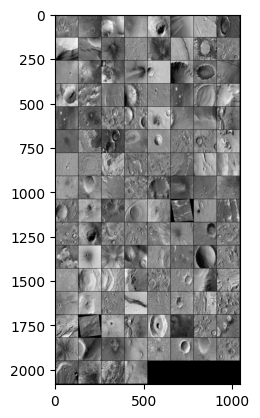

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    if code==1:
        img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [8]:
class GlobalAvgPool2d(nn.Module):
    # Define a PyTorch module for global average pooling
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()
        
    # Define the forward pass method for the module
    def forward(self, x):
        return nn.functional.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)

In [9]:
# Define a module for 2D unpooling
class MyUnpool2d(nn.Module):
    def __init__(self, scale_factor):
        super(MyUnpool2d, self).__init__()
        self.scale_factor = scale_factor

    def forward(self, x):
        # Perform 2D unpooling using bilinear interpolation
        return nn.functional.interpolate(x, scale_factor=self.scale_factor, mode='nearest')

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.conv1 = nn.Conv2d(NUM_CHANNELS, 64, 11,padding=11//2)
        self.pool = nn.MaxPool2d(2, stride=2, return_indices=True)                                    
        self.conv2 = nn.Conv2d(64, 128, 7,padding=7//2)
        # self.pool2 = nn.MaxPool2d(2, stride=2, return_indices=True) 
        self.conv3 = nn.Conv2d(128, 128, 5,padding=5//2)


        
        self.fcEnc = nn.Sequential(
                                    nn.Linear(128*16* 16, 120),
                                    nn.ReLU(True),
                                    nn.Linear(120, 84),
                                    nn.ReLU(True),
                                    nn.Linear(84, 40))
        

        self.unpool_layer1 = MyUnpool2d(scale_factor=2)

        self.fcDec = nn.Sequential(
                                    nn.Linear(40, 84),
                                    nn.ReLU(True),
                                    nn.Linear(84, 120),
                                    nn.ReLU(True),
                                    nn.Linear(120, 128 * 16 * 16),
                                    nn.ReLU(True),
                                    nn.Unflatten(1, (128, 16, 16))

        )

        self.convt1 = nn.ConvTranspose2d(128, 128, 5,padding=5//2)
        self.unpool = nn.MaxUnpool2d(2, 2)
                        
        
                                    
        self.convt2 =  nn.ConvTranspose2d(128, 64, 7,padding=7//2)

        self.convt3 = nn.ConvTranspose2d(64, NUM_CHANNELS, 11,padding=11//2)




    def forward(self, x):
        # print(x.shape)

        x = self.conv1(x)
        # print(x.shape)
        x,indices1 = self.pool(x)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)

        x,indices2 = self.pool(x)
        # print(x.shape)
        x = F.relu(self.conv3(x))
        # print(x.shape)
        x,indices2 = self.pool(x)
        # 
        # print(x.shape)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.fcEnc(x)
        # print(x.shape)
        x = self.fcDec(x)
        # print(x.shape)




        # print(x.shape)
        x = self.unpool_layer1(x)
        x = self.convt1(x) # print(x.shape)
        x = self.unpool_layer1(x)
        # print(x.shape)
        x =  self.convt2(x)
        # print(x.shape)
        x = self.unpool_layer1(x)
        # print(x.shape)
        x = F.sigmoid( self.convt3(x))
        # print(x.shape)
        return x


    def compress(self,x):
        x = self.conv1(x)
        # print(x.shape)
        x,indices1 = self.pool(x)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)

        x,indices2 = self.pool(x)
        # print(x.shape)
        x = F.relu(self.conv3(x))
        # print(x.shape)
        x,indices2 = self.pool(x)
        # 
        # print(x.shape)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.fcEnc(x)

        return x
    
    def decompress(self,compressed,indices):
        x = self.fcDec(compressed)

        x = F.relu(self.convt1(x))
net = Autoencoder()


In [11]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [13]:
net.to(device)

Autoencoder(
  (conv1): Conv2d(1, 64, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fcEnc): Sequential(
    (0): Linear(in_features=32768, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=40, bias=True)
  )
  (unpool_layer1): MyUnpool2d()
  (fcDec): Sequential(
    (0): Linear(in_features=40, out_features=84, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=84, out_features=120, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=120, out_features=32768, bias=True)
    (5): ReLU(inplace=True)
    (6): Unflatten(dim=1, unflattened_size=(128, 16, 16))
  )
  (convt1): C

In [14]:
input_data = torch.randn(1, NUM_CHANNELS, 128, 128).to(device)  # Example input tensor of shape (batch_size, channels, height, width)
output_data = net(input_data)  # Forward pass through the autoencoder
# loss = F.mse_loss(output_data, input_data)  # Compute MSE loss between output and input
# print(loss)

In [15]:
input_data.shape

torch.Size([1, 1, 128, 128])

In [16]:
output_data.shape

torch.Size([1, 1, 128, 128])

In [17]:
from tqdm import tqdm

In [18]:
len(trainloader), len(testloader)

(1, 5)

In [19]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm



criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)


In [ ]:


# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)  

for epoch in tqdm(range(15000)):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data

        optimizer.zero_grad()
        
        outputs = net(inputs.to(device))
        loss = criterion(outputs, inputs.to(device))
        loss.backward()
        optimizer.step()

        
        # running_loss += loss.item()
        # if i % 2 == 0:   
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2:.3f}')
        #     running_loss = 0.0
    if epoch%50==0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')
    
    optimizer.step()

print('Finished Training')


(3, 132, 522)


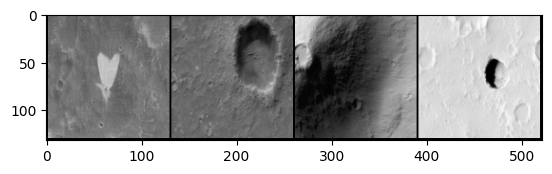

In [20]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

## Saving the Model

In [ ]:
from datetime import datetime
now = datetime.now()

In [ ]:
f'{now}'

In [ ]:
root = 'models'

In [ ]:
f'{loss.item():.4f}'

In [ ]:
f'{root}/{datasetNames[code-1]}-{now}-{loss.item():.4f}.pth'

In [ ]:
torch.save(net.state_dict(), f'{root}/{datasetNames[code-1]}-{now}-{loss.item():.4f}.pth')

## Loading the saved model

In [21]:
import os

print(f"Options Are: {os.listdir('models')}")

Options Are: ['MNIST-2024-04-13 23:34:19.095483-0.0007.pth', 'MNIST-2024-04-12 22:36:39.511709-0.0010.pth', 'Moon_Craters-2024-04-13 02:48:53.422161-0.0060.pth', 'Moon_Craters-2024-04-13 02:19:45.432084-0.0063.pth', 'Moon_Craters-2024-04-13 01:32:40.360655-0.0253.pth', 'Moon_Craters-2024-04-13 18:56:05.024679-0.0009.pth', 'FashionMNIST-2024-04-12 22:44:18.962585-0.0025.pth', 'Moon_Craters-2024-04-13 05:02:58.809573-0.0026.pth', 'CIFAR10-2024-04-13 23:39:45.200790-0.1501.pth', 'CIFAR10-2024-04-12 23:05:46.035186-0.1568.pth', 'Moon_Craters-2024-04-13 01:45:10.732340-0.0453.pth', 'Moon_Craters-2024-04-13 01:36:45.303256-0.0250.pth', 'FashionMNIST-2024-04-13 22:51:17.457683-0.0037.pth', 'Moon_Craters-2024-04-13 21:32:40.449914-0.0031.pth', 'Moon_Craters-2024-04-13 02:49:20.415492-0.0105.pth', 'Moon_Craters-2024-04-13 02:06:39.657056-0.0080.pth', 'Moon_Craters-2024-04-13 02:21:16.453948-0.0061.pth']


In [22]:
net.load_state_dict(torch.load(f'models/Moon_Craters-2024-04-13 18:56:05.024679-0.0009.pth'))

<All keys matched successfully>

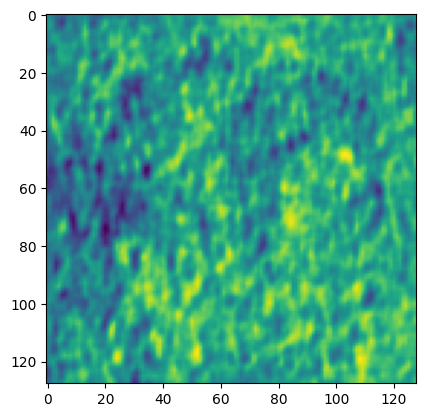

In [23]:
dataiter = iter(testloader)
images, labels = next(dataiter)

outputs = net(images.to(device))

plt.imshow(outputs[3].detach().cpu().permute(1,2,0))



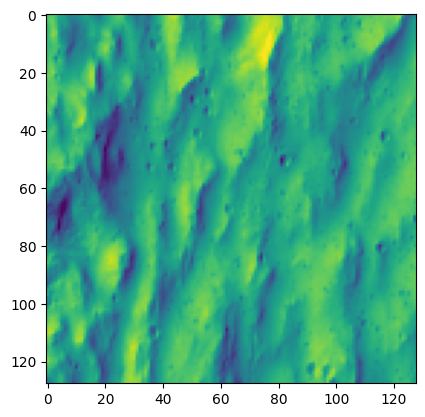

In [24]:
plt.imshow(images[3].detach().cpu().permute(1,2,0))

## Benchmarking on Test Dataset

In [25]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

# Define the loss function
criterion = nn.MSELoss()

running_loss = 0.0
# Iterate over the test data loader

for i, data in tqdm(enumerate(testloader, 0)):
    inputs, labels = data

    outputs = net(inputs.to(device))
    # Compute the loss between the outputs and the inputs
    loss = criterion(outputs, inputs.to(device))


print(f'Test Loss: {loss.item()}')

5it [00:00,  9.56it/s]

Test Loss: 0.010069610550999641


## SSIM

In [26]:
import numpy as np
from skimage.metrics import structural_similarity as compare_ssim


criterion = nn.MSELoss()

running_loss = 0.0

tSSIM = 0

# Iterate over the train data loader

for i, data in tqdm(enumerate(trainloader, 0)):
    inputs, labels = data

    outputs = net(inputs.to(device))

    # Convert PyTorch tensors to NumPy arrays and change dimensions for SSIM calculation
    batchNumpyIP = inputs.permute((0,2,3,1)).detach().cpu().numpy()
    batchNumpyOP = outputs.permute((0,2,3,1)).detach().cpu().numpy()



    loss = criterion(outputs, inputs.to(device))

print(f'Train Loss: {loss.item()}')
# print(f'Mean MSSIM for Train data is: {tSSIM/(4*len(trainloader))}')


1it [00:00,  2.45it/s]

Train Loss: 0.0008894523489288986


In [27]:
len(testloader)

5

In [28]:
tSSIM

0

In [29]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

# Initialize an empty tensor to store the results
resFull = torch.tensor([])


running_loss = 0.0
for i, data in tqdm(enumerate(trainloader, 0)):
    inputs, labels = data

    # Pass the inputs through the compression part of the network
    outputs = net.compress(inputs.to(device))
    resFull = torch.cat([resFull, outputs[0].detach().cpu()], dim=0)


1it [00:00,  3.30it/s]


In [30]:
toSave = resFull.numpy()

In [31]:
np.save(f'{datasetNames[code-1]}-compressed.npy',toSave)

In [32]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

resFull = torch.tensor([])


running_loss = 0.0
for i, data in tqdm(enumerate(trainloader, 0)):
    inputs, labels = data

    # outputs = net.compress(inputs.to(device))
    resFull = torch.cat([resFull, inputs], dim=0)


1it [00:00,  3.97it/s]


In [33]:
toSave = resFull.numpy()

In [32]:
np.save(f'{datasetNames[code-1]}-og.npy',toSave)